<a href="https://colab.research.google.com/github/ehsung/PUBH6886/blob/main/PUBH6886_FinalProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Install Libraries
install.packages("caret")
install.packages("ggplot2")
install.packages("pROC")
install.packages("leaps")
install.packages("glmnet")
install.packages("pls")
install.packages("gridExtra")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("randomForest")
install.packages("gbm")
install.packages("naivebayes")
install.packages("psych")
install.packages("naniar")
install.packages("reshape2")
install.packages("doParallel")
install.packages("kernlab")

In [ ]:
# Load libraries
library(readr)
library(dplyr)
library(caret)
library(ggplot2)
library(pROC)
library(leaps)
library(glmnet)
library(pls)
library(gridExtra)
library(rpart)
library(rpart.plot)
library(randomForest)
library(gbm)
library(splines)
library(naivebayes)
library(psych)
library(naniar)
library(reshape2)
library(doParallel)
library(kernlab)

# Load and Clean the Data

In [ ]:
# Load the diabetes_012_health_indicators_BRFSS2015.csv data
diabetes_rawData <- read_csv("/content/diabetes_012_health_indicators_BRFSS2015.csv")

In [4]:
# Check the loaded data (Transposed for easier full viewing)
t(head(diabetes_rawData))

Diabetes_012,0,0,0,0,0,0
HighBP,1,0,1,1,1,1
HighChol,1,0,1,0,1,1
CholCheck,1,0,1,1,1,1
BMI,40,25,28,27,24,25
Smoker,1,1,0,0,0,1
Stroke,0,0,0,0,0,0
HeartDiseaseorAttack,0,0,0,0,0,0
PhysActivity,0,1,0,1,1,1
Fruits,0,0,1,1,1,1
Veggies,1,0,0,1,1,1


In [5]:
# Shape of the dataset
dim(diabetes_rawData)

[1] 253680     22

In [6]:
# Value Count and Class Distrubtion of Response (Diabetes)
table(diabetes_rawData$Diabetes_012)


     0      1      2 
213703   4631  35346 

In [7]:
# Due to the computational resources and the need for class balance in machine learning models
# For initial machine learning development, I decided for a simple approach by:
# Keeping all of the value 2 -- diabetes (Target Interest)
# Removing all of the value 1 -- prediabetes (Off Target Interest, so not needed)
# Randomly Subset the value 0 -- no diabetes (Match number of yes diabetes for balanced class)

set.seed(123)

# Keeping all of the value 2; Removing all of the value 1
diabetes_subset <- diabetes_rawData %>%
  filter(Diabetes_012 == 2)

# Randomly Subset the value 0
sampling_size <- sum(diabetes_rawData$Diabetes_012 == 2)

tmp_diabetes_0 <- diabetes_rawData %>%
  filter(Diabetes_012 == 0) %>%
  sample_n(size = sampling_size, replace = FALSE)

# Combine the subset dataframes into a new dataset
diabetes_newData <- rbind(diabetes_subset, tmp_diabetes_0)

# Rename Diabetes_012 to just Diabetes
diabetes_newData <- diabetes_newData %>%
  rename(Diabetes = Diabetes_012) %>%
  mutate(Diabetes = ifelse(Diabetes == 2, "Yes", "No")) # Convert to '2 = Yes' and '0 = No'

table(diabetes_newData$Diabetes)


   No   Yes 
35346 35346 

In [8]:
# Shape of the new dataset
dim(diabetes_newData)

[1] 70692    22

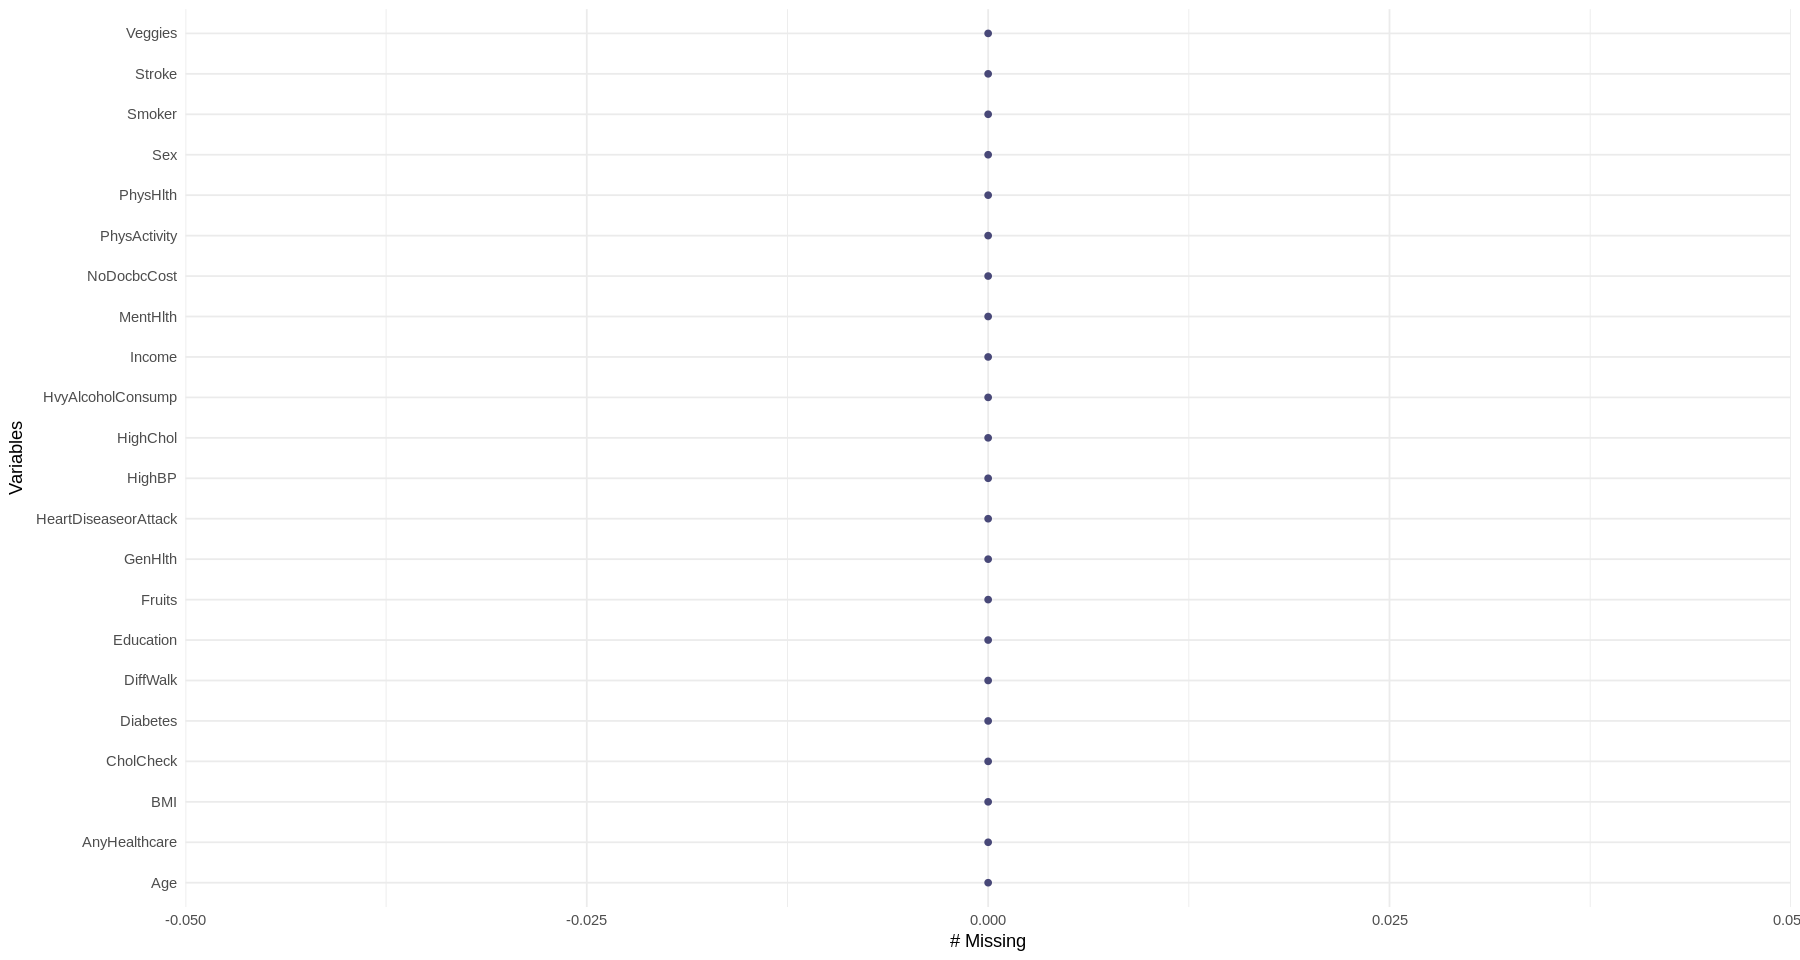

In [9]:
# Check for missing data -- There are no missing data
options(repr.plot.width = 15, repr.plot.height = 8)

gg_miss_var(diabetes_newData)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


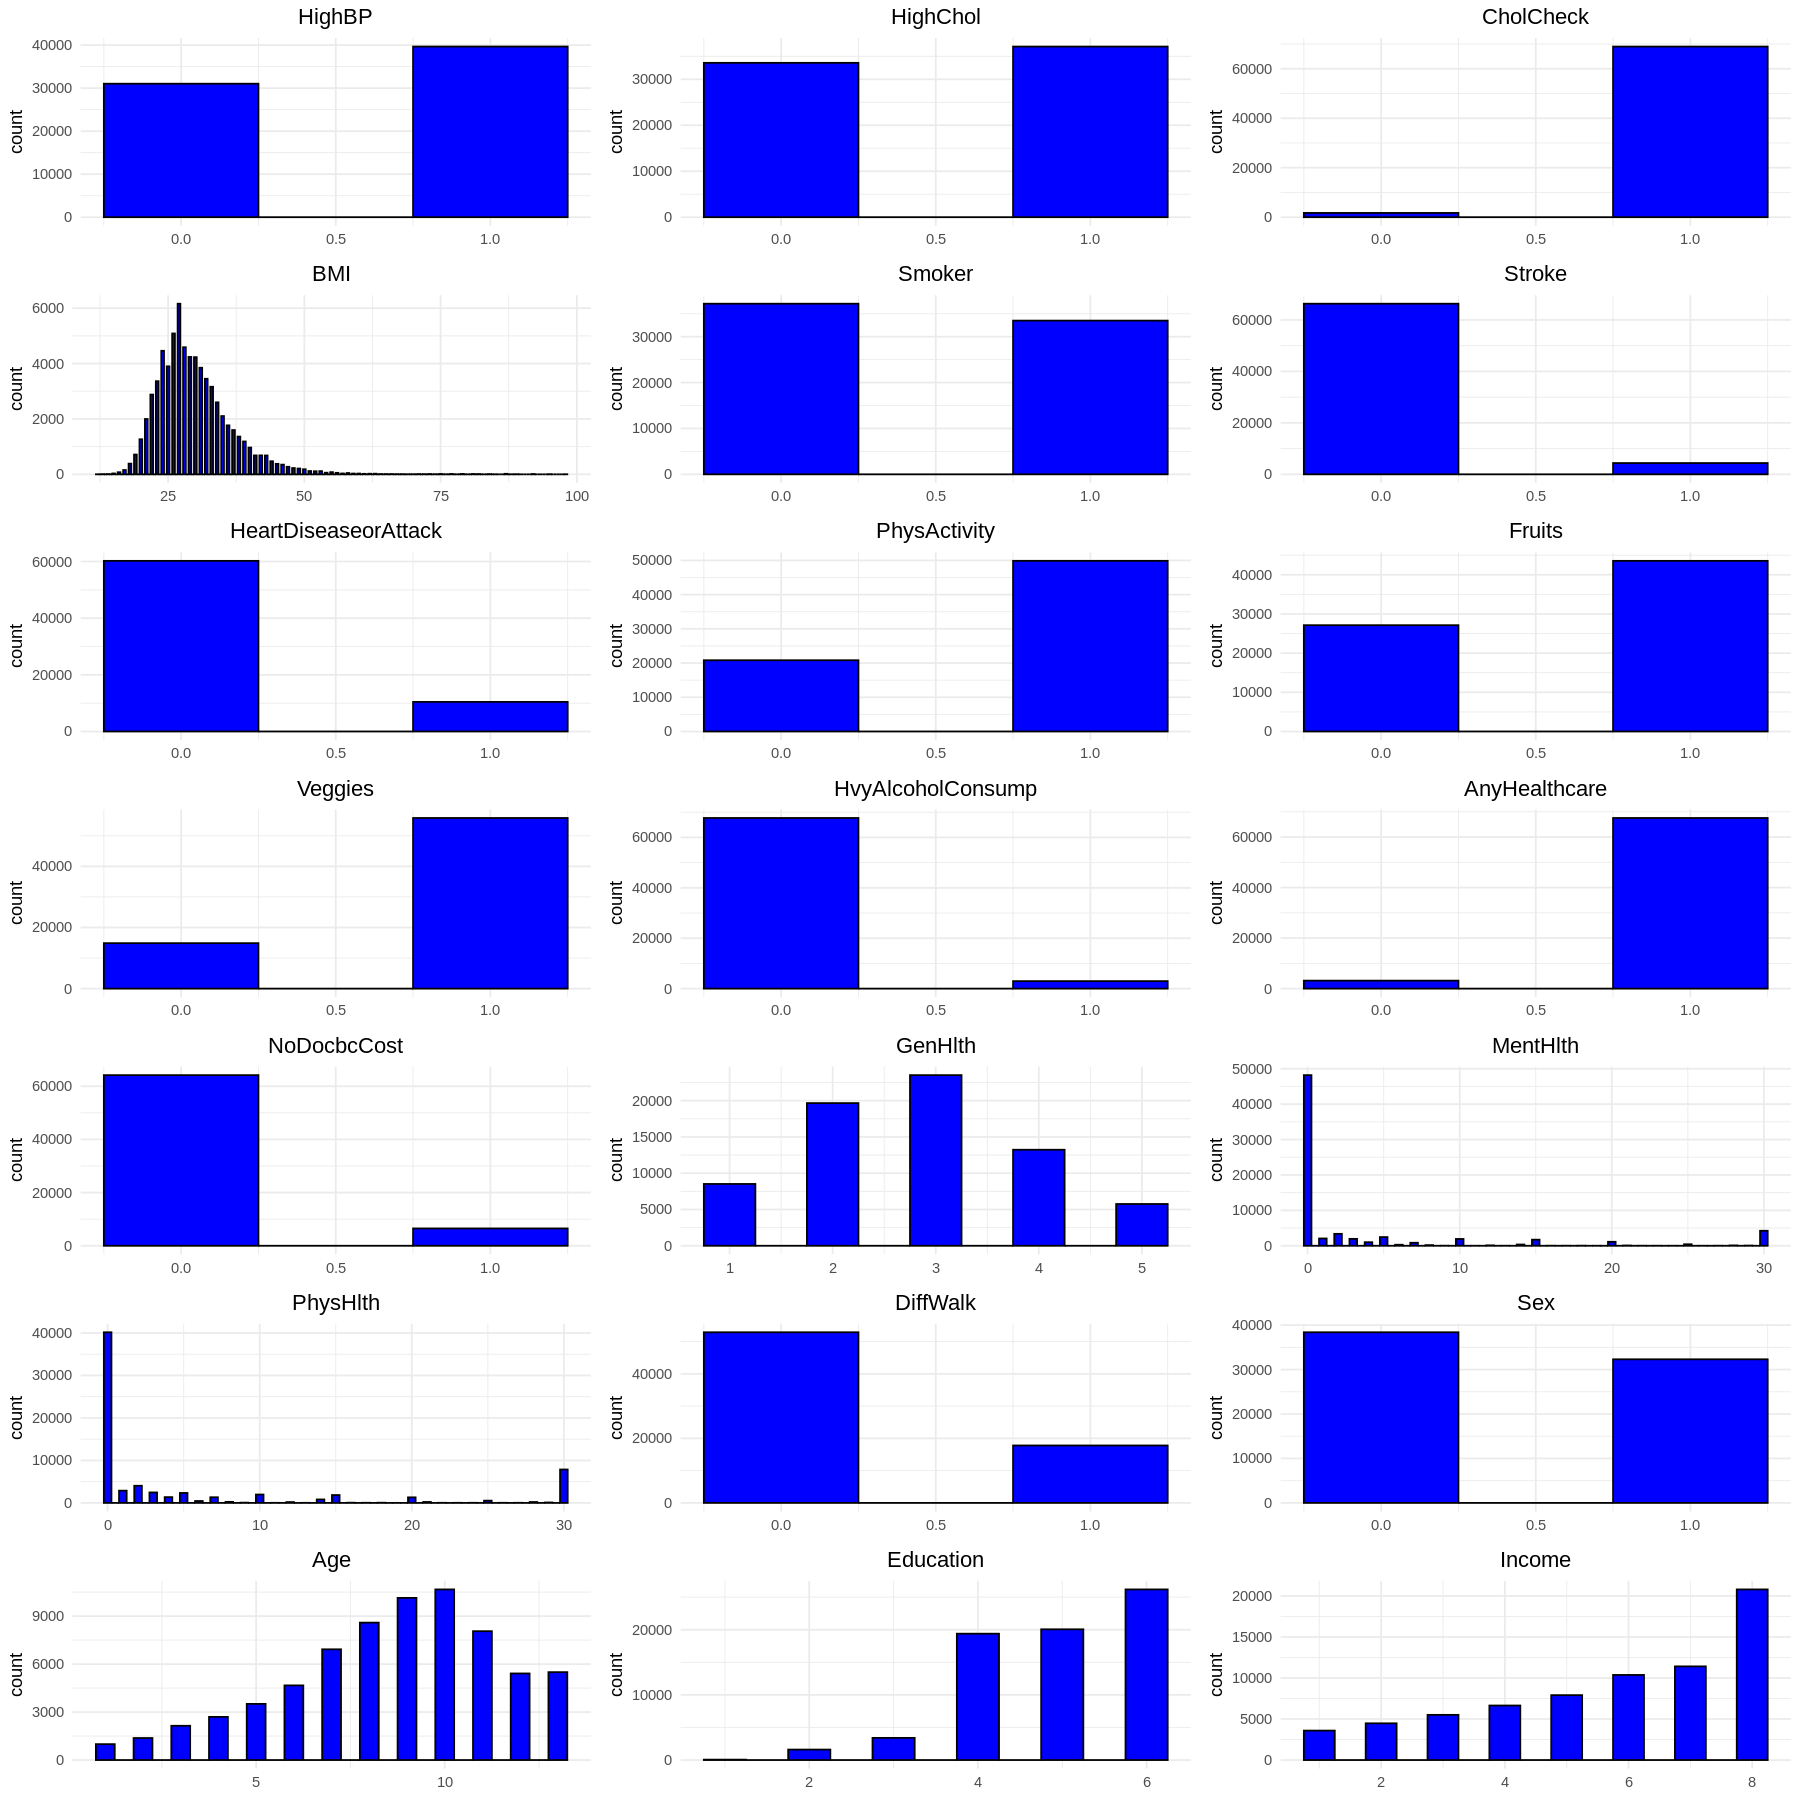

In [10]:
# Plot all feature columns to see distribution and to evaluate if it needs to be factored as a catagorical
options(repr.plot.width = 15, repr.plot.height = 15)

hist_plots <- lapply(names(diabetes_newData)[names(diabetes_newData) != "Diabetes"], function(col) {
  ggplot(diabetes_newData, aes_string(x = col)) +
    geom_histogram(binwidth = 0.5, fill = "blue", color = "black") +
    theme_minimal() +
    ggtitle(col) +
    theme(
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_blank()
    )
})

# Plot and arrange in a grid
grid.arrange(grobs = hist_plots, ncol = 3, padding = uni(2, "cm"))

In [11]:
# Looks like BMI is the only numerical feature, all other are catagorical, which will be factored
diabetes_newData <- diabetes_newData %>%
  mutate(across(c(Diabetes,
                  HighBP,
                  HighChol,
                  CholCheck,
                  Smoker,
                  Stroke,
                  HeartDiseaseorAttack,
                  PhysActivity,
                  Fruits,
                  Veggies,
                  HvyAlcoholConsump,
                  AnyHealthcare,
                  NoDocbcCost,
                  GenHlth,
                  MentHlth,
                  PhysHlth,
                  DiffWalk,
                  Sex,
                  Age,
                  Education,
                  Income), as.factor))

str(diabetes_newData)

tibble [70,692 × 22] (S3: tbl_df/tbl/data.frame)
 $ Diabetes            : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ HighBP              : Factor w/ 2 levels "0","1": 2 1 2 1 2 2 2 2 2 2 ...
 $ HighChol            : Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 2 2 2 ...
 $ CholCheck           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ BMI                 : num [1:70692] 30 25 28 23 27 37 28 27 34 24 ...
 $ Smoker              : Factor w/ 2 levels "0","1": 2 2 1 2 1 2 2 2 2 2 ...
 $ Stroke              : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 2 1 ...
 $ HeartDiseaseorAttack: Factor w/ 2 levels "0","1": 2 1 1 1 1 2 2 1 1 1 ...
 $ PhysActivity        : Factor w/ 2 levels "0","1": 1 2 1 2 2 1 1 1 2 1 ...
 $ Fruits              : Factor w/ 2 levels "0","1": 2 2 1 1 2 1 1 2 1 1 ...
 $ Veggies             : Factor w/ 2 levels "0","1": 2 2 2 1 2 2 2 2 1 1 ...
 $ HvyAlcoholConsump   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ AnyHealthcare       : Fac

In [12]:
# Split the data for a hidden test_data for final evaluation
# But also further reduce the training data size due to computational limits
# Split 40% train_data, 60% test_data
set.seed(123)

train_index <- createDataPartition(diabetes_newData$Diabetes, p = 0.40, list = FALSE)

train_data <- diabetes_newData[train_index, ]
test_data <- diabetes_newData[-train_index, ]

# Save the splits into to csv
# write.csv(train_data, file = "cleaned_train_data.csv", row.names = FALSE)
# write.csv(test_data, file = "cleaned_test_data.csv", row.names = FALSE)

In [13]:
# Size of train_data
dim(train_data)

[1] 28278    22

In [14]:
# Size of test_data
dim(test_data)

[1] 42414    22

In [15]:
# Double check balance class distribution in train data
table(train_data$Diabetes)


   No   Yes 
14139 14139 

In [16]:
# Double check balance class distribution in test data
table(test_data$Diabetes)


   No   Yes 
21207 21207 

# Visualizing the train_data set

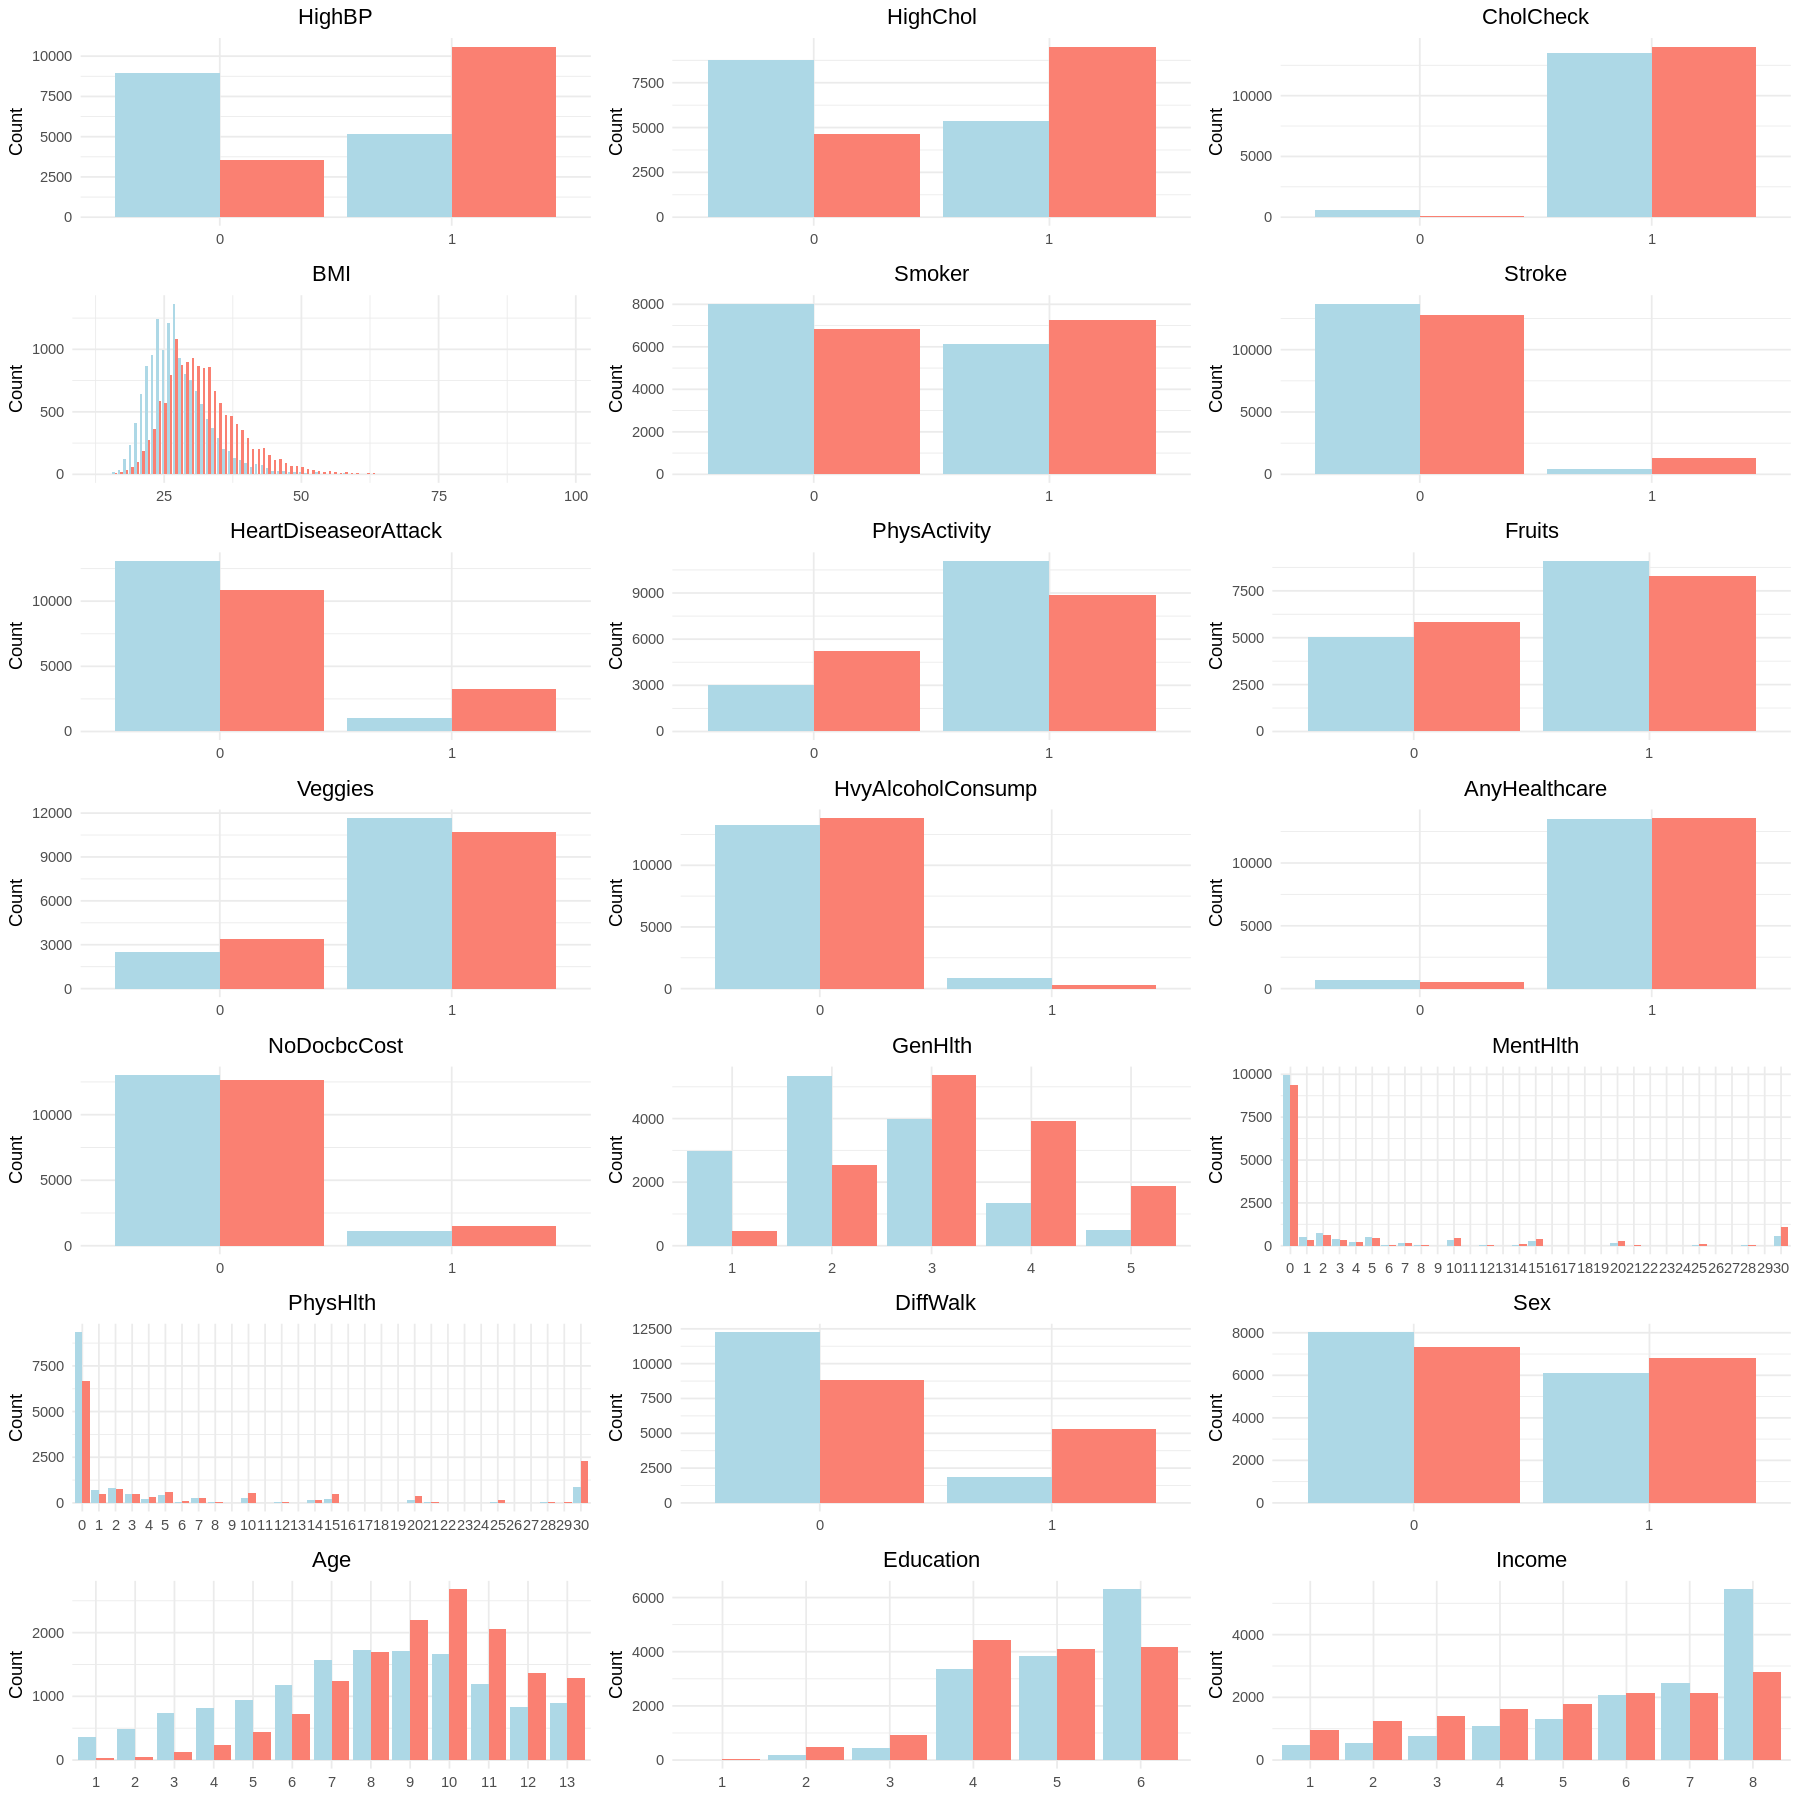

In [53]:
# Same histogram plots, but in relation to the target predictor (Diabetes)
# Blue is No - Diabetes
# Red is Yes - Diabetes
options(repr.plot.width = 15, repr.plot.height = 15)

predictors <- colnames(train_data)[colnames(train_data) != "Diabetes"]

hist_plots <- lapply(predictors, function(predictor) {
  ggplot(train_data, aes(x = .data[[predictor]], fill = Diabetes)) +
    suppressWarnings(geom_histogram(stat = "count", position = "dodge")) +
    labs(x = predictor,
         y = "Count") +
    theme_minimal() +
    scale_fill_manual(values = c("No" = "lightblue", "Yes" = "salmon")) +
    ggtitle(predictor) +
    theme(
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_blank(),
      legend.position = "none"
    )
})

grid.arrange(grobs = hist_plots, ncol = 3, padding = uni(2, "cm"))

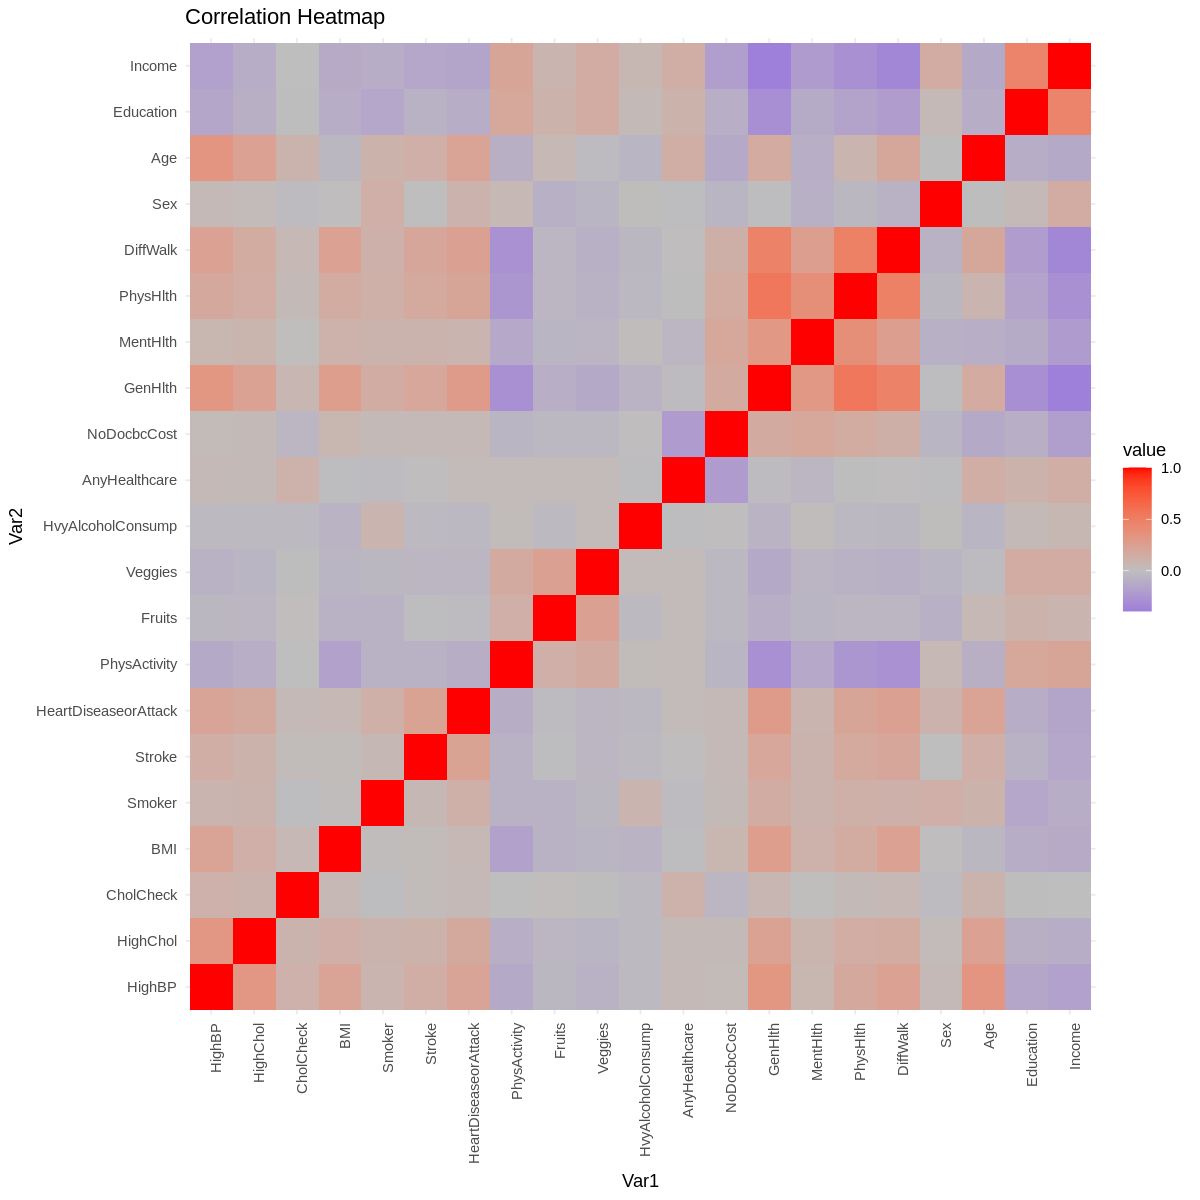

In [33]:
# Correlation Plot using heatmap
options(repr.plot.width = 10, repr.plot.height = 10)

# Convert back to numeric temporarily
df_numeric <- data.frame(lapply(train_data[, names(train_data) != "Diabetes"], function(x) as.numeric(as.character(x))))

# Correlation calculation
cor_matrix <- cor(df_numeric, use = "complete.obs", method = "pearson")

# Correlation Heatmap
cor_melted <- melt(cor_matrix)

ggplot(cor_melted, aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "grey", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap")

# Exploring Generalized Modeling

In [34]:
# Baseline Models
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Baseline train_control, just 10 cross validation
train_control_baseline <- trainControl(method = "cv", number = 10, allowParallel = TRUE)

In [35]:
# Logistic Regression
logit_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "glm", family = "binomial", trControl = train_control_baseline))

In [36]:
# K-Nearest Neighbors (KNN)
knn_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "knn", trControl = train_control_baseline))

In [37]:
# Naive Bayes
nb_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "naive_bayes", trControl = train_control_baseline))

In [38]:
# Linear Discriminant Analysis (LDA)
lda_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "lda", trControl = train_control_baseline))

In [39]:
# Quadratic Discriminant Analysis (QDA)
qda_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "qda", trControl = train_control_baseline))

In [40]:
# Ridge Classifier
ridge_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "glmnet", tuneGrid = expand.grid(alpha = 0, lambda = 0), trControl = train_control_baseline))

In [41]:
# Lasso Classifier
lasso_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "glmnet", tuneGrid = expand.grid(alpha = 1, lambda = 0), trControl = train_control_baseline))

In [42]:
# Elastic Net Classifier
elastic_net_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "glmnet", tuneGrid = expand.grid(alpha = c(0.1, 0.5, 0.9), lambda = 0), trControl = train_control_baseline))

In [43]:
# Decision Tree Classifier
decision_tree_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "rpart", trControl = train_control_baseline))

In [44]:
# Random Forest Classifier
random_forest_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "rf", trControl = train_control_baseline))

In [ ]:
# Boosting Tree Classifier
boosting_tree_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "gbm", trControl = train_control_baseline))

In [46]:
# Support Vector Machine (SVM) Classifier
svm_model_baseline <- suppressWarnings(train(Diabetes ~ ., data = train_data, method = "svmLinear", trControl = train_control_baseline))

In [47]:
# Close parallel processing
stopCluster(cl)

# Create a comparison table
classifier_baseline <- c("Logistic_Regression",
                         "K_Neares_Neighbors",
                         "Naive_Bayes",
                         "Linear_Discriminant_Analysis",
                         "Quadratic_Discriminant_Analysis",
                         "Ridge_Classifier",
                         "Lasso_Classifier",
                         "Elastic Net Classifier",
                         "Decision_Tree_Classifier",
                         "Random_Forest_Classifier",
                         "Boosting Tree Classifier",
                         "Support Vector Machine_Classifier")

classifier_baseline_accuracy <- c(max(logit_model_baseline$results$Accuracy),
                                  max(knn_model_baseline$results$Accuracy),
                                  max(nb_model_baseline$results$Accuracy),
                                  max(lda_model_baseline$results$Accuracy),
                                  max(qda_model_baseline$results$Accuracy),
                                  max(ridge_model_baseline$results$Accuracy),
                                  max(lasso_model_baseline$results$Accuracy),
                                  max(elastic_net_model_baseline$results$Accuracy),
                                  max(decision_tree_model_baseline$results$Accuracy),
                                  max(random_forest_model_baseline$results$Accuracy),
                                  max(boosting_tree_model_baseline$results$Accuracy),
                                  max(svm_model_baseline$results$Accuracy))

In [48]:
# Create a table and graph of the baseline results
classifier_baseline_df <- data.frame(Classifier = classifier_baseline,
                                     Accuracy = classifier_baseline_accuracy)

classifier_baseline_df

Classifier,Accuracy
<chr>,<dbl>
Logistic_Regression,0.7518923
K_Neares_Neighbors,0.7227174
Naive_Bayes,0.6375632
Linear_Discriminant_Analysis,0.7524926
Quadratic_Discriminant_Analysis,0.6530963
Ridge_Classifier,0.7510788
Lasso_Classifier,0.7525638
Elastic Net Classifier,0.7526341
Decision_Tree_Classifier,0.7048588


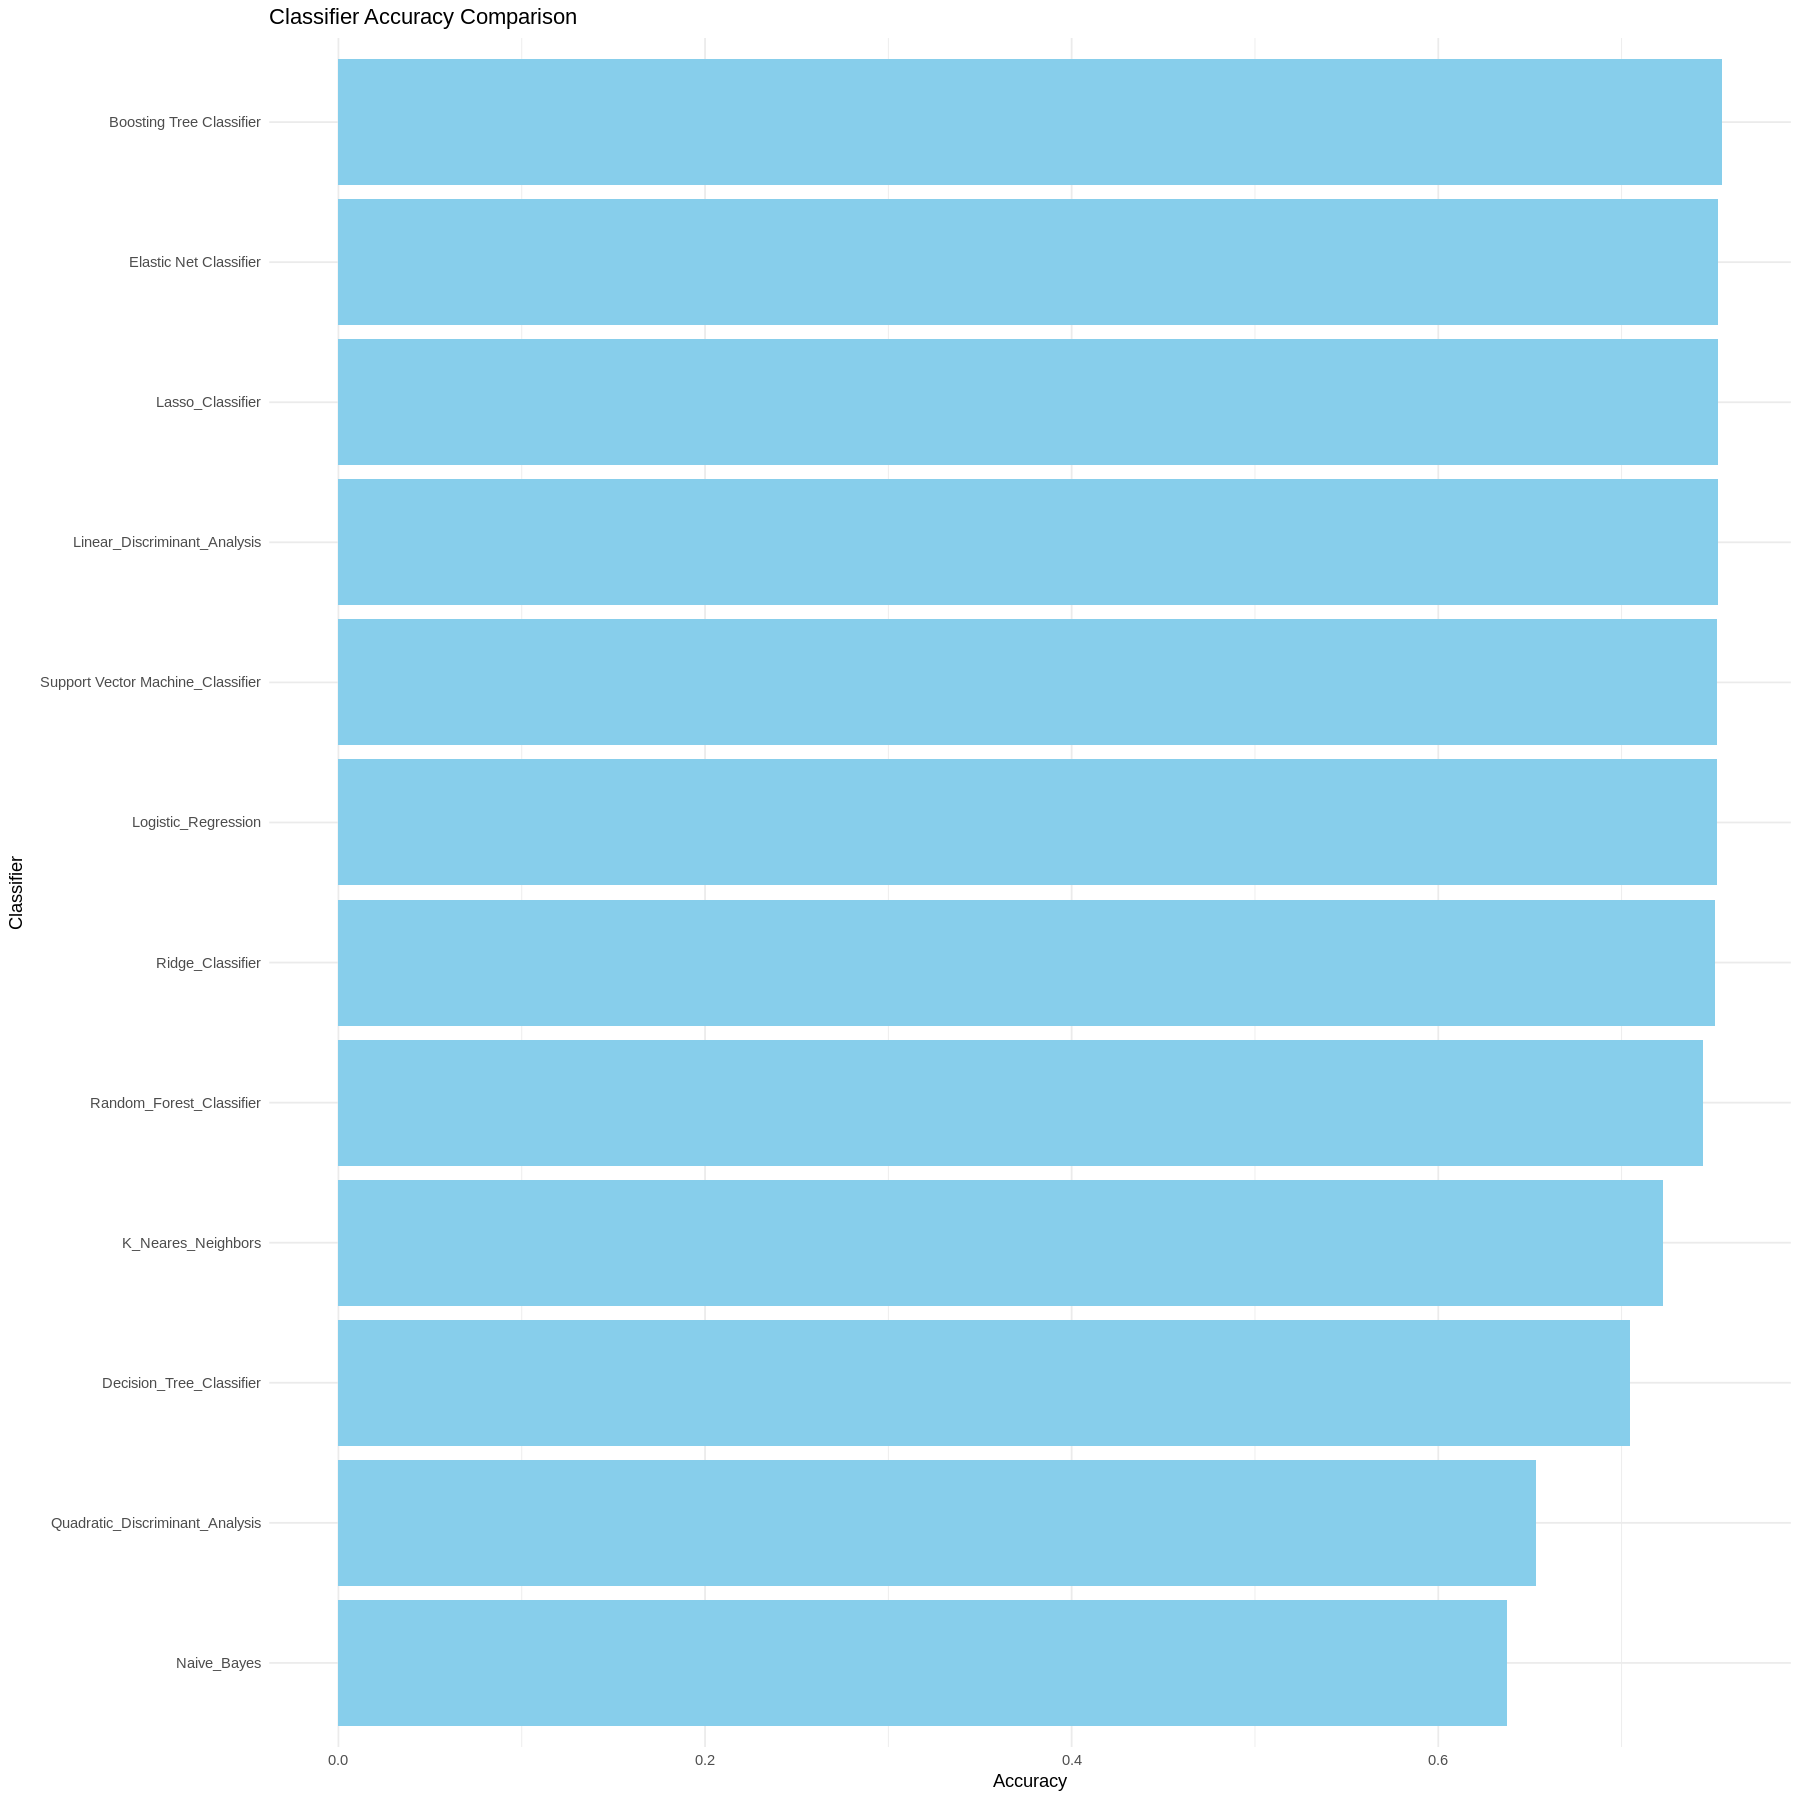

In [54]:
# Create the bar plot
ggplot(classifier_baseline_df, aes(x = reorder(Classifier, Accuracy), y = Accuracy)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +
  labs(title = "Classifier Accuracy Comparison",
       x = "Classifier",
       y = "Accuracy") +
  theme_minimal()

# Hyperparameter Tuning the Top 3 Models

## Boosting Tree Classifier - Rough Tune

In [17]:
# Set seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Boosting tuning grid for hyperparameters
tuning_grid_boostingTree <- expand.grid(n.trees = c(200, 400, 600),
                                        interaction.depth = c(1, 2, 3),
                                        shrinkage = c(0.01, 0.1, 0.5),
                                        n.minobsinnode = c(10, 30, 60))

train_control_boostingTree <- trainControl(method = "cv",
                                           number = 10,
                                           allowParallel = TRUE)

In [ ]:
# Boosting Tree Classifier - Rough Tune
boosting_tree_model_GridTuned_Rough <- suppressWarnings(train(Diabetes ~ .,
                                                              data = train_data,
                                                              method = "gbm",
                                                              distribution = "bernoulli",
                                                              bag.fraction = 0.50,
                                                              tuneGrid = tuning_grid_boostingTree,
                                                              trControl = train_control_boostingTree))

stopCluster(cl)

In [20]:
boosting_tree_model_GridTuned_Rough$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<dbl>,<dbl>,<dbl>
42,600,2,0.1,30


## Boosting Tree Classifier - Fine Tune

In [21]:
# Set seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Boosting tuning grid for hyperparameters
tuning_grid_boostingTree_fine <- expand.grid(n.trees = c(500, 600, 700, 800),
                                        interaction.depth = c(1, 2, 3),
                                        shrinkage = c(0.05, 0.1, 0.15),
                                        n.minobsinnode = c(20, 30, 40))

train_control_boostingTree_fine <- trainControl(method = "cv",
                                           number = 10,
                                           allowParallel = TRUE)

In [ ]:
# Boosting Tree Classifier - Fine Tune
boosting_tree_model_GridTuned_Fine <- suppressWarnings(train(Diabetes ~ .,
                                                             data = train_data,
                                                             method = "gbm",
                                                             distribution = "bernoulli",
                                                             bag.fraction = 0.50,
                                                             tuneGrid = tuning_grid_boostingTree_fine,
                                                             trControl = train_control_boostingTree_fine))

stopCluster(cl)

In [32]:
boosting_tree_model_GridTuned_Fine$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<dbl>,<dbl>,<dbl>
54,600,2,0.1,30


In [33]:
# Associated Best Accuracy
boosting_tree_model_GridTuned_Fine$results[boosting_tree_model_GridTuned_Fine$results$n.trees == boosting_tree_model_GridTuned_Fine$bestTune$n.trees &
                                           boosting_tree_model_GridTuned_Fine$results$interaction.depth == boosting_tree_model_GridTuned_Fine$bestTune$interaction.depth &
                                           boosting_tree_model_GridTuned_Fine$results$shrinkage == boosting_tree_model_GridTuned_Fine$bestTune$shrinkage &
                                           boosting_tree_model_GridTuned_Fine$results$n.minobsinnode == boosting_tree_model_GridTuned_Fine$bestTune$n.minobsinnode,]

,shrinkage,interaction.depth,n.minobsinnode,n.trees,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54,0.1,2,30,600,0.7566308,0.5132617,0.008927643,0.01785455


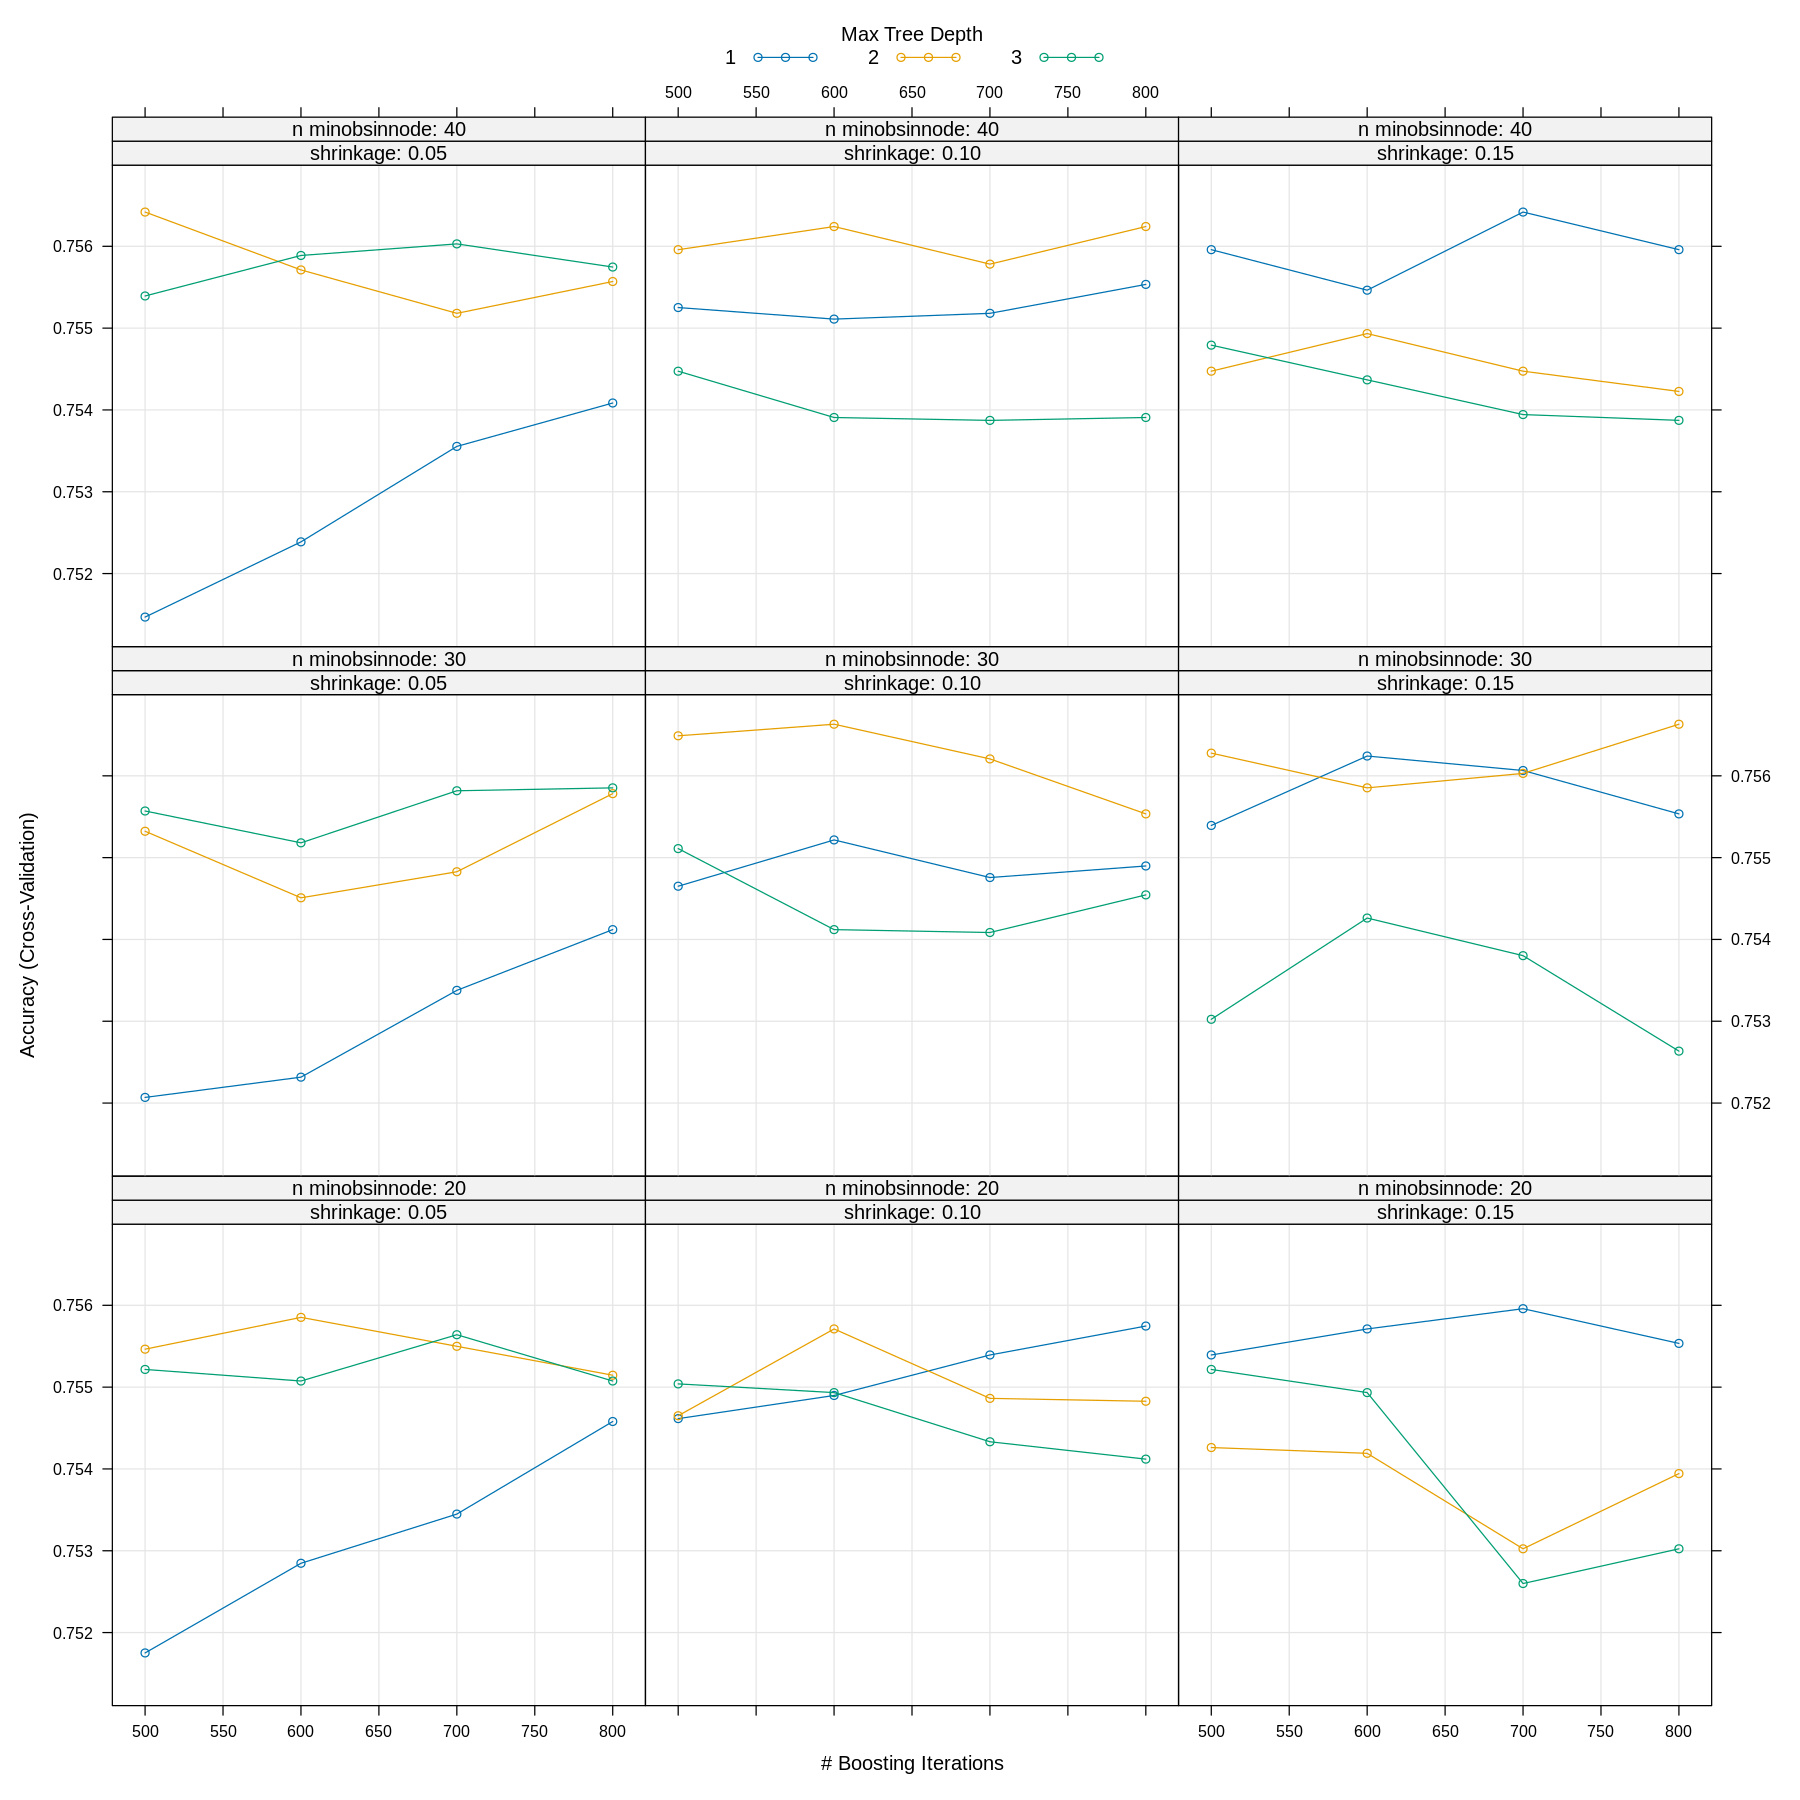

In [34]:
# Assuming 'boosting_tree_model_tuned' is your trained model
plot(boosting_tree_model_GridTuned_Fine, metric = "Accuracy") # Or other relevant metric

## Elastic Net Classifier - Rough Tune

In [41]:
# Set seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Elastic Net tuning grid for hyperparameters
tuning_grid_ElasticNet <- expand.grid(alpha = seq(0, 1, by = 0.1),
                                      lambda = seq(0.0001, 0.1, length.out = 100))

train_control_ElasticNet <- trainControl(method = "cv",
                                         number = 10,
                                         allowParallel = TRUE)

In [42]:
# Elastic Net Classifier - Rough Tune
elastic_net_model_GridTuned_Rough <- suppressWarnings(train(Diabetes ~ .,
                                                            data = train_data,
                                                            method = "glmnet",
                                                            scale = TRUE,
                                                            tuneGrid = tuning_grid_ElasticNet,
                                                            trControl = train_control_ElasticNet))

stopCluster(cl)

In [43]:
# Best rough parameters
elastic_net_model_GridTuned_Rough$bestTune

,alpha,lambda
,<dbl>,<dbl>
402,0.4,0.001109091


## Elastic Net Classifier - Fine Tune

In [44]:
# Reuce the hyperparameter space to an even tighter area around what was found as the bestTune in the rough

# Set seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Elastic Net tuning grid for hyperparameters
tuning_grid_ElasticNet_fine <- expand.grid(alpha = seq(0.1, 0.6, by = 0.05),
                                           lambda = 10^seq(-6, -2, length = 20))

train_control_ElasticNet_fine <- trainControl(method = "cv",
                                              number = 10,
                                              allowParallel = TRUE)

In [45]:
# Elastic Net Classifier - Fine Tune
elastic_net_model_GridTuned_Fine <- suppressWarnings(train(Diabetes ~ .,
                                                           data = train_data,
                                                           method = "glmnet",
                                                           scale = TRUE,
                                                           tuneGrid = tuning_grid_ElasticNet_fine,
                                                           trControl = train_control_ElasticNet_fine))

stopCluster(cl)

In [46]:
# Best fine parameters
elastic_net_model_GridTuned_Fine$bestTune

,alpha,lambda
,<dbl>,<dbl>
54,0.2,0.0005455595


In [47]:
# Associated Best Accuracy
elastic_net_model_GridTuned_Fine$results[elastic_net_model_GridTuned_Fine$results$alpha == elastic_net_model_GridTuned_Fine$bestTune$alpha &
                                         elastic_net_model_GridTuned_Fine$results$lambda == elastic_net_model_GridTuned_Fine$bestTune$lambda, ]

,alpha,lambda,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54,0.2,0.0005455595,0.7529179,0.5058358,0.009356341,0.01871235


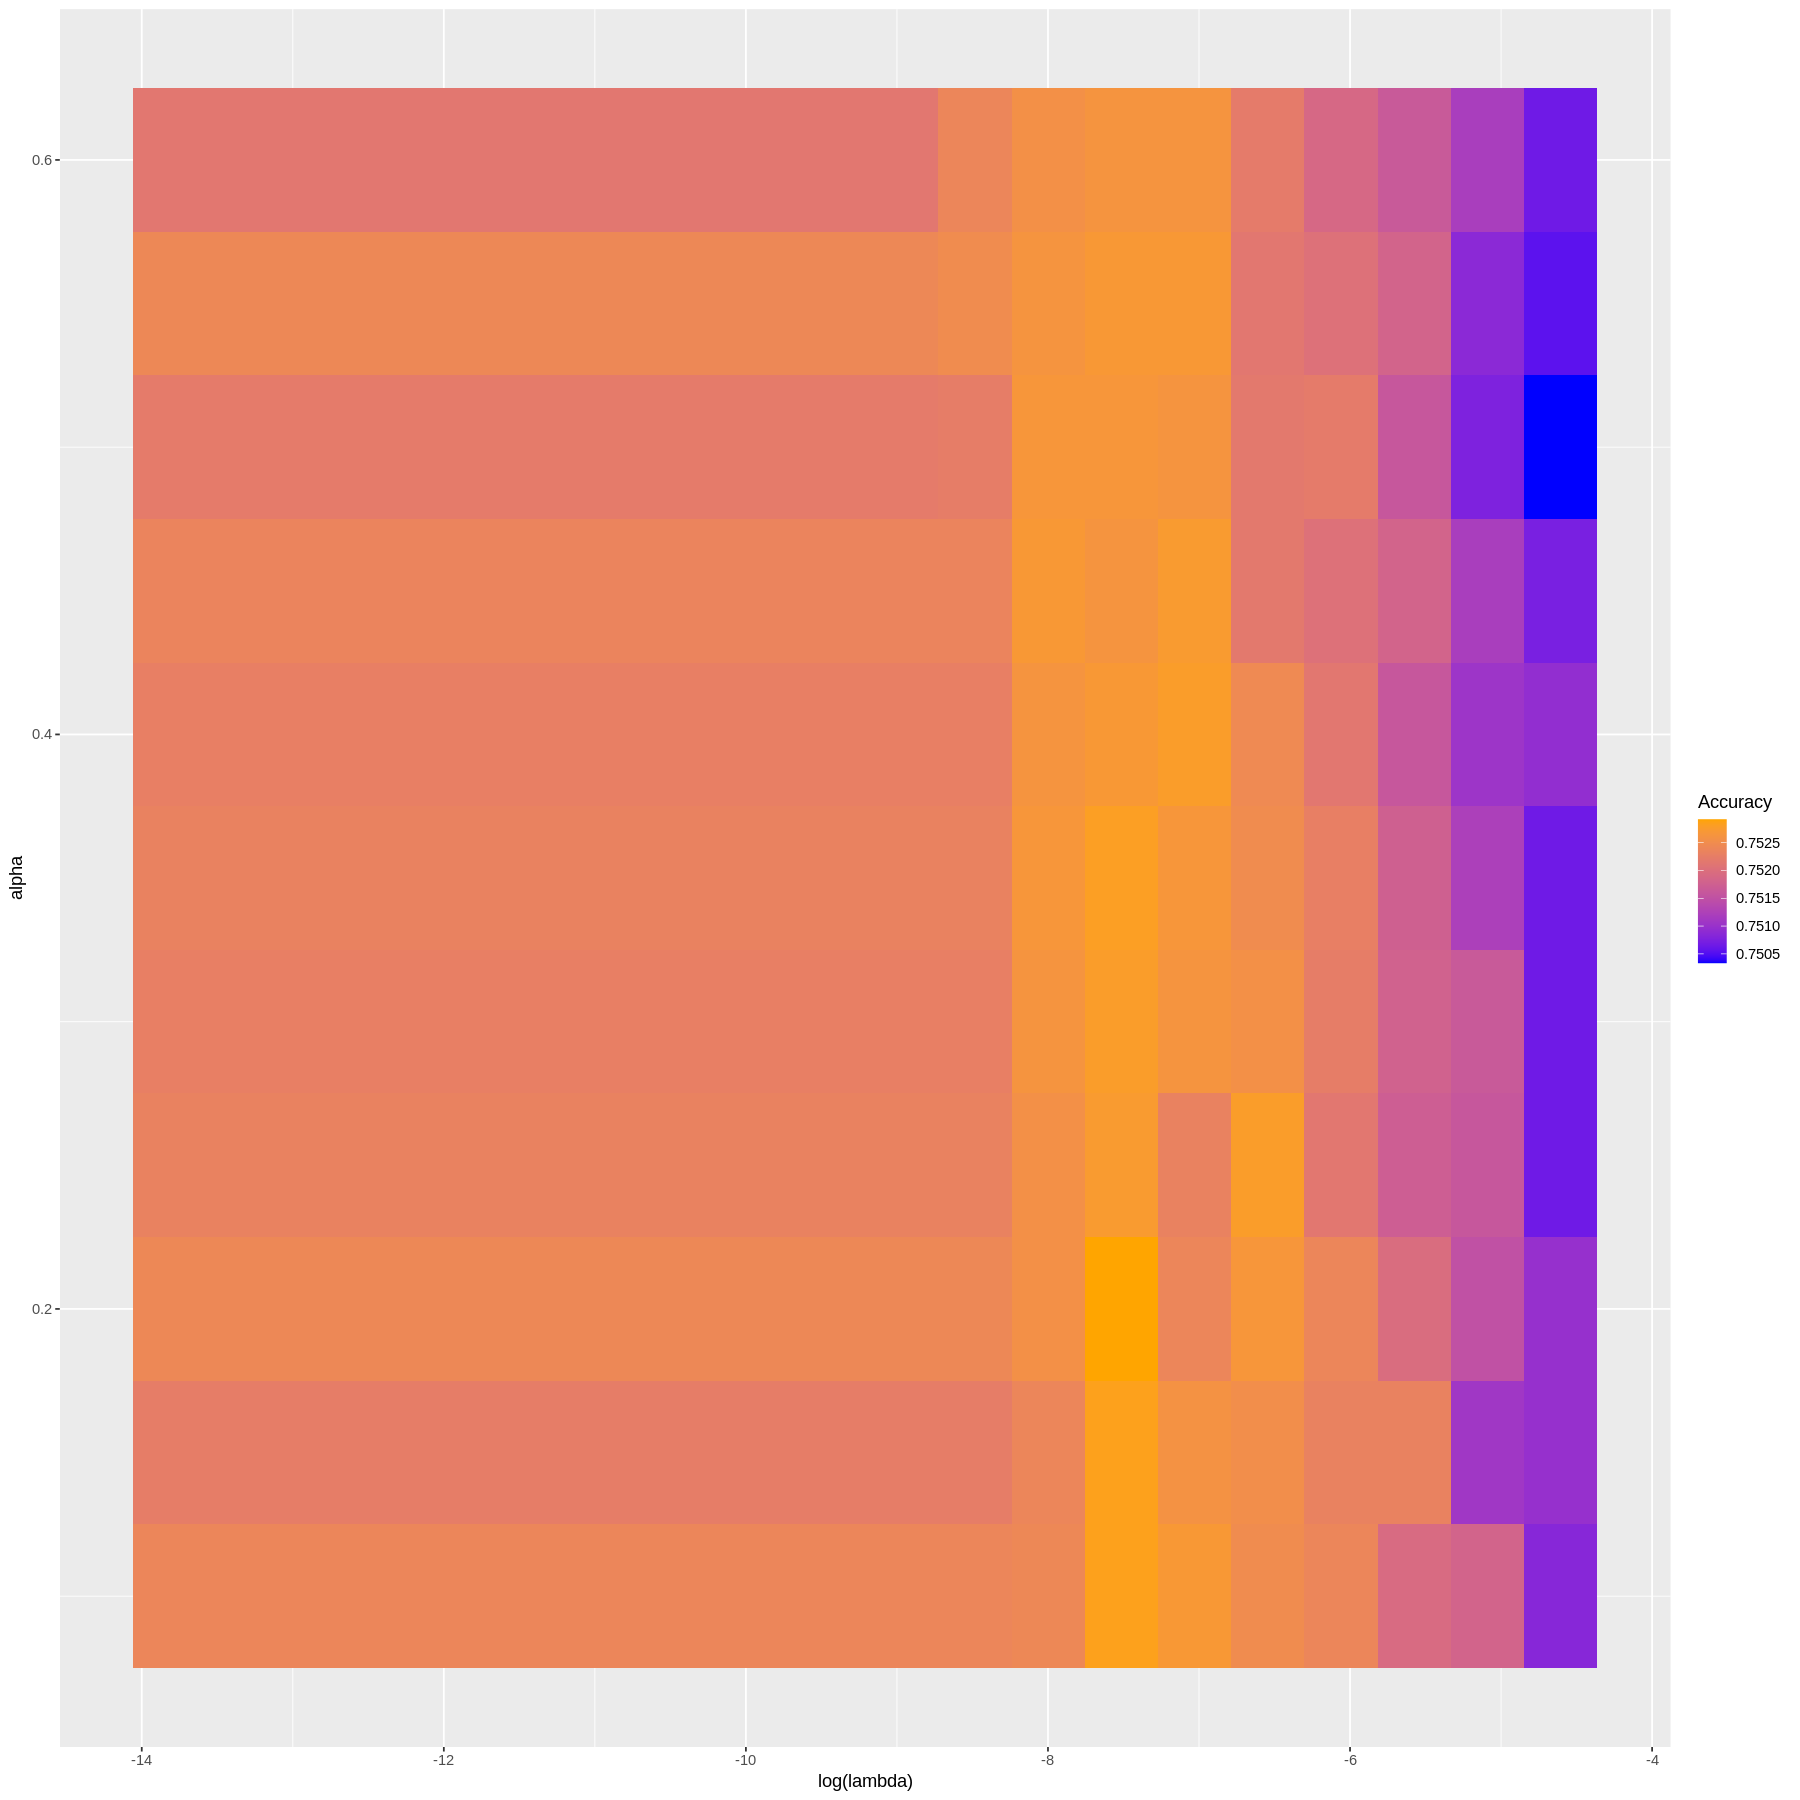

In [48]:
# Heatmap used to support best parameters are found
elastic_net_model_GridTuned_Fine$results %>%
  ggplot(aes(x = log(lambda), y = alpha, fill = Accuracy)) +
  geom_tile() +
  scale_fill_gradient(low = "blue", high = "orange")

# Support Vector Machine Classifier - Rough Tune

In [52]:
# Identify which kernal type to use for svm
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# Baseline train_control, just 10 cross validation
train_control_svm <- trainControl(method = "cv", number = 10, allowParallel = TRUE)

svm_model_linear <- suppressWarnings(train(Diabetes ~ .,
                                           data = train_data,
                                           method = "svmLinear",
                                           trControl = train_control_svm))

svm_model_poly <- suppressWarnings(train(Diabetes ~ .,
                                         data = train_data,
                                         method = "svmPoly",
                                         trControl = train_control_svm))

svm_model_radial <- suppressWarnings(train(Diabetes ~ .,
                                           data = train_data,
                                           method = "svmRadial",
                                           trControl = train_control_svm))

stopCluster(cl)

In [53]:
# svmLinear Best Accuracy
max(svm_model_linear$results$Accuracy)

[1] 0.7429944

In [54]:
# svmPoly Best Accuracy
max(svm_model_poly$results$Accuracy)

[1] 0.7536101

In [55]:
# svmRadial Best Accuracy
max(svm_model_radial$results$Accuracy)

[1] 0.7448261

In [56]:
# Moving forward with svmPoly

# Set Seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# SVM tuning grid for hyperparameters
tuning_grid_svm <- expand.grid(degree = c(2, 3),
                               scale = c(0.5, 1, 1.5),
                               C = c(0.01, 1))


train_control_svm <- trainControl(method = "cv",
                                  number = 10,
                                  allowParallel = TRUE)

In [57]:
# SVM Classifier - Rough Tune
svm_model_poly_GridTuned_Rough <- suppressWarnings(train(Diabetes ~ .,
                                                   data = train_data,
                                                   method = "svmPoly",
                                                   scale = TRUE,
                                                   tuneGrid = tuning_grid_svm,
                                                   trControl = train_control_svm))
stopCluster(cl)

In [60]:
svm_model_poly_GridTuned_Rough$bestTune

,degree,scale,C
,<dbl>,<dbl>,<dbl>
1,2,0.5,0.01


# Support Vector Machine Classifier - Fine Tune

In [62]:
# Moving forward with svmPoly

# Set Seed
set.seed(123)

# Setup parallel processing
num_cores <- 40
cl <- makePSOCKcluster(num_cores)
registerDoParallel(cl)

# SVM tuning grid for hyperparameters
tuning_grid_svm_fine <- expand.grid(degree = c(1, 2, 3),
                               scale = c(0.01, 0.2, 0.5, 0.7),
                               C = c(0.001, 0.01, 0.05))


train_control_svm_fine <- trainControl(method = "cv",
                                  number = 10,
                                  allowParallel = TRUE)

In [63]:
# SVM Classifier - Fine Tune
svm_model_poly_GridTuned_Fine <- suppressWarnings(train(Diabetes ~ .,
                                                   data = train_data,
                                                   method = "svmPoly",
                                                   scale = TRUE,
                                                   tuneGrid = tuning_grid_svm_fine,
                                                   trControl = train_control_svm_fine))
stopCluster(cl)

In [64]:
svm_model_poly_GridTuned_Fine$bestTune

,degree,scale,C
,<dbl>,<dbl>,<dbl>
9,1,0.5,0.05


In [65]:
# Associated Best Accuracy
svm_model_poly_GridTuned_Fine$results[svm_model_poly_GridTuned_Fine$results$degree == svm_model_poly_GridTuned_Fine$bestTune$degree &
                                      svm_model_poly_GridTuned_Fine$results$scale == svm_model_poly_GridTuned_Fine$bestTune$scale &
                                      svm_model_poly_GridTuned_Fine$results$C == svm_model_poly_GridTuned_Fine$bestTune$C,]

,degree,scale,C,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,1,0.5,0.05,0.7500822,0.5002487,0.0321446,0.06434338


# Final Validation on Hidden Test Set

In [36]:
# Check the hidden test_data generated at start of code
dim(test_data)

[1] 42414    22

In [37]:
table(test_data$Diabetes)


   No   Yes 
21207 21207 

## Boosting Tree Classifier Performance

In [39]:
# Make predictions using the final model
predictions_boosting_tree <- predict(boosting_tree_model_GridTuned_Fine, newdata = test_data)

# Generate confusion_matrix
confusion_matrix_boosting_tree <- confusionMatrix(predictions_boosting_tree, test_data$Diabetes)

# Print output
print(confusion_matrix_boosting_tree)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  15344  4668
       Yes  5863 16539
                                          
               Accuracy : 0.7517          
                 95% CI : (0.7476, 0.7558)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5034          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7235          
            Specificity : 0.7799          
         Pos Pred Value : 0.7667          
         Neg Pred Value : 0.7383          
             Prevalence : 0.5000          
         Detection Rate : 0.3618          
   Detection Prevalence : 0.4718          
      Balanced Accuracy : 0.7517          
                                          
       'Positive' Class : No              
                  

,var,rel.inf
,<chr>,<dbl>
HighBP1,HighBP1,28.8369945
BMI,BMI,17.2276962
HighChol1,HighChol1,9.4288560
GenHlth4,GenHlth4,6.3956144
DiffWalk1,DiffWalk1,6.3150048
GenHlth3,GenHlth3,3.7338487
GenHlth2,GenHlth2,3.7033466
HeartDiseaseorAttack1,HeartDiseaseorAttack1,3.3194789
GenHlth5,GenHlth5,2.8053633


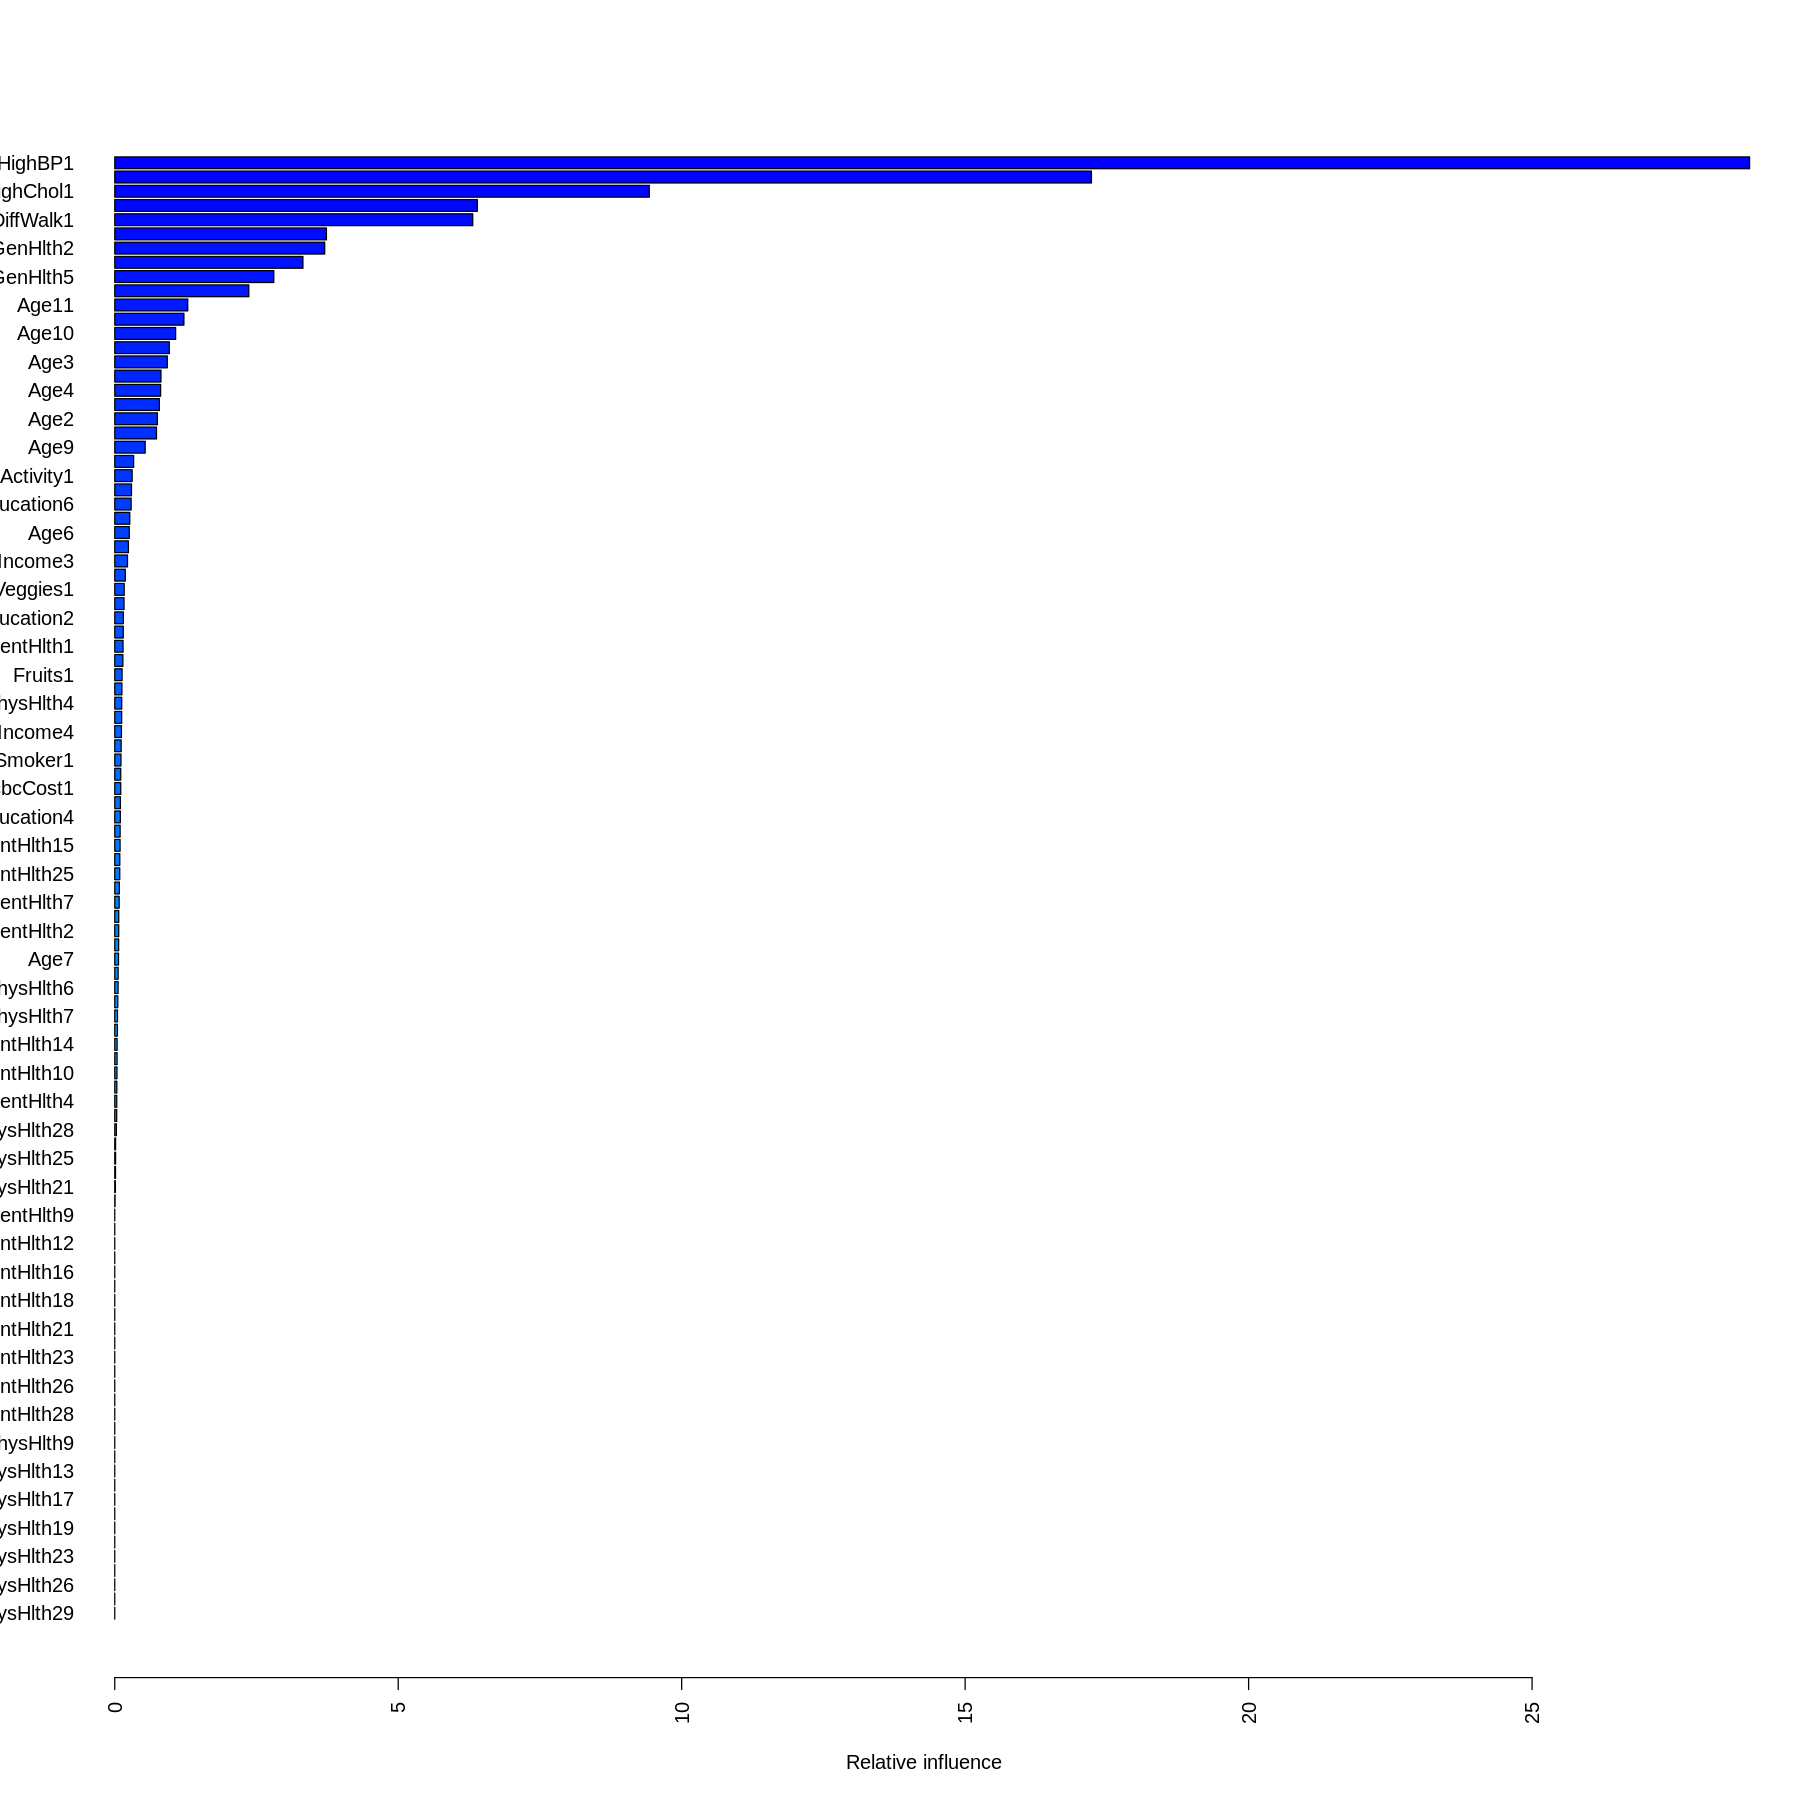

In [40]:
# Generate associated Feature Importance
summary(boosting_tree_model_GridTuned_Fine$finalModel,
  method = relative.influence,
  normalize = TRUE, las = 2)

## Elastic Net Classifier Performance

In [58]:
# Make predictions using the final model
predictions_elastic_net <- predict(elastic_net_model_GridTuned_Fine, newdata = test_data)

# Generate confusion_matrix
confusion_matrix_elastic_net <- confusionMatrix(predictions_elastic_net, test_data$Diabetes)

# Print output
print(confusion_matrix_elastic_net)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  15455  4886
       Yes  5752 16321
                                         
               Accuracy : 0.7492         
                 95% CI : (0.745, 0.7533)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.4984         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.7288         
            Specificity : 0.7696         
         Pos Pred Value : 0.7598         
         Neg Pred Value : 0.7394         
             Prevalence : 0.5000         
         Detection Rate : 0.3644         
   Detection Prevalence : 0.4796         
      Balanced Accuracy : 0.7492         
                                         
       'Positive' Class : No             
                                      

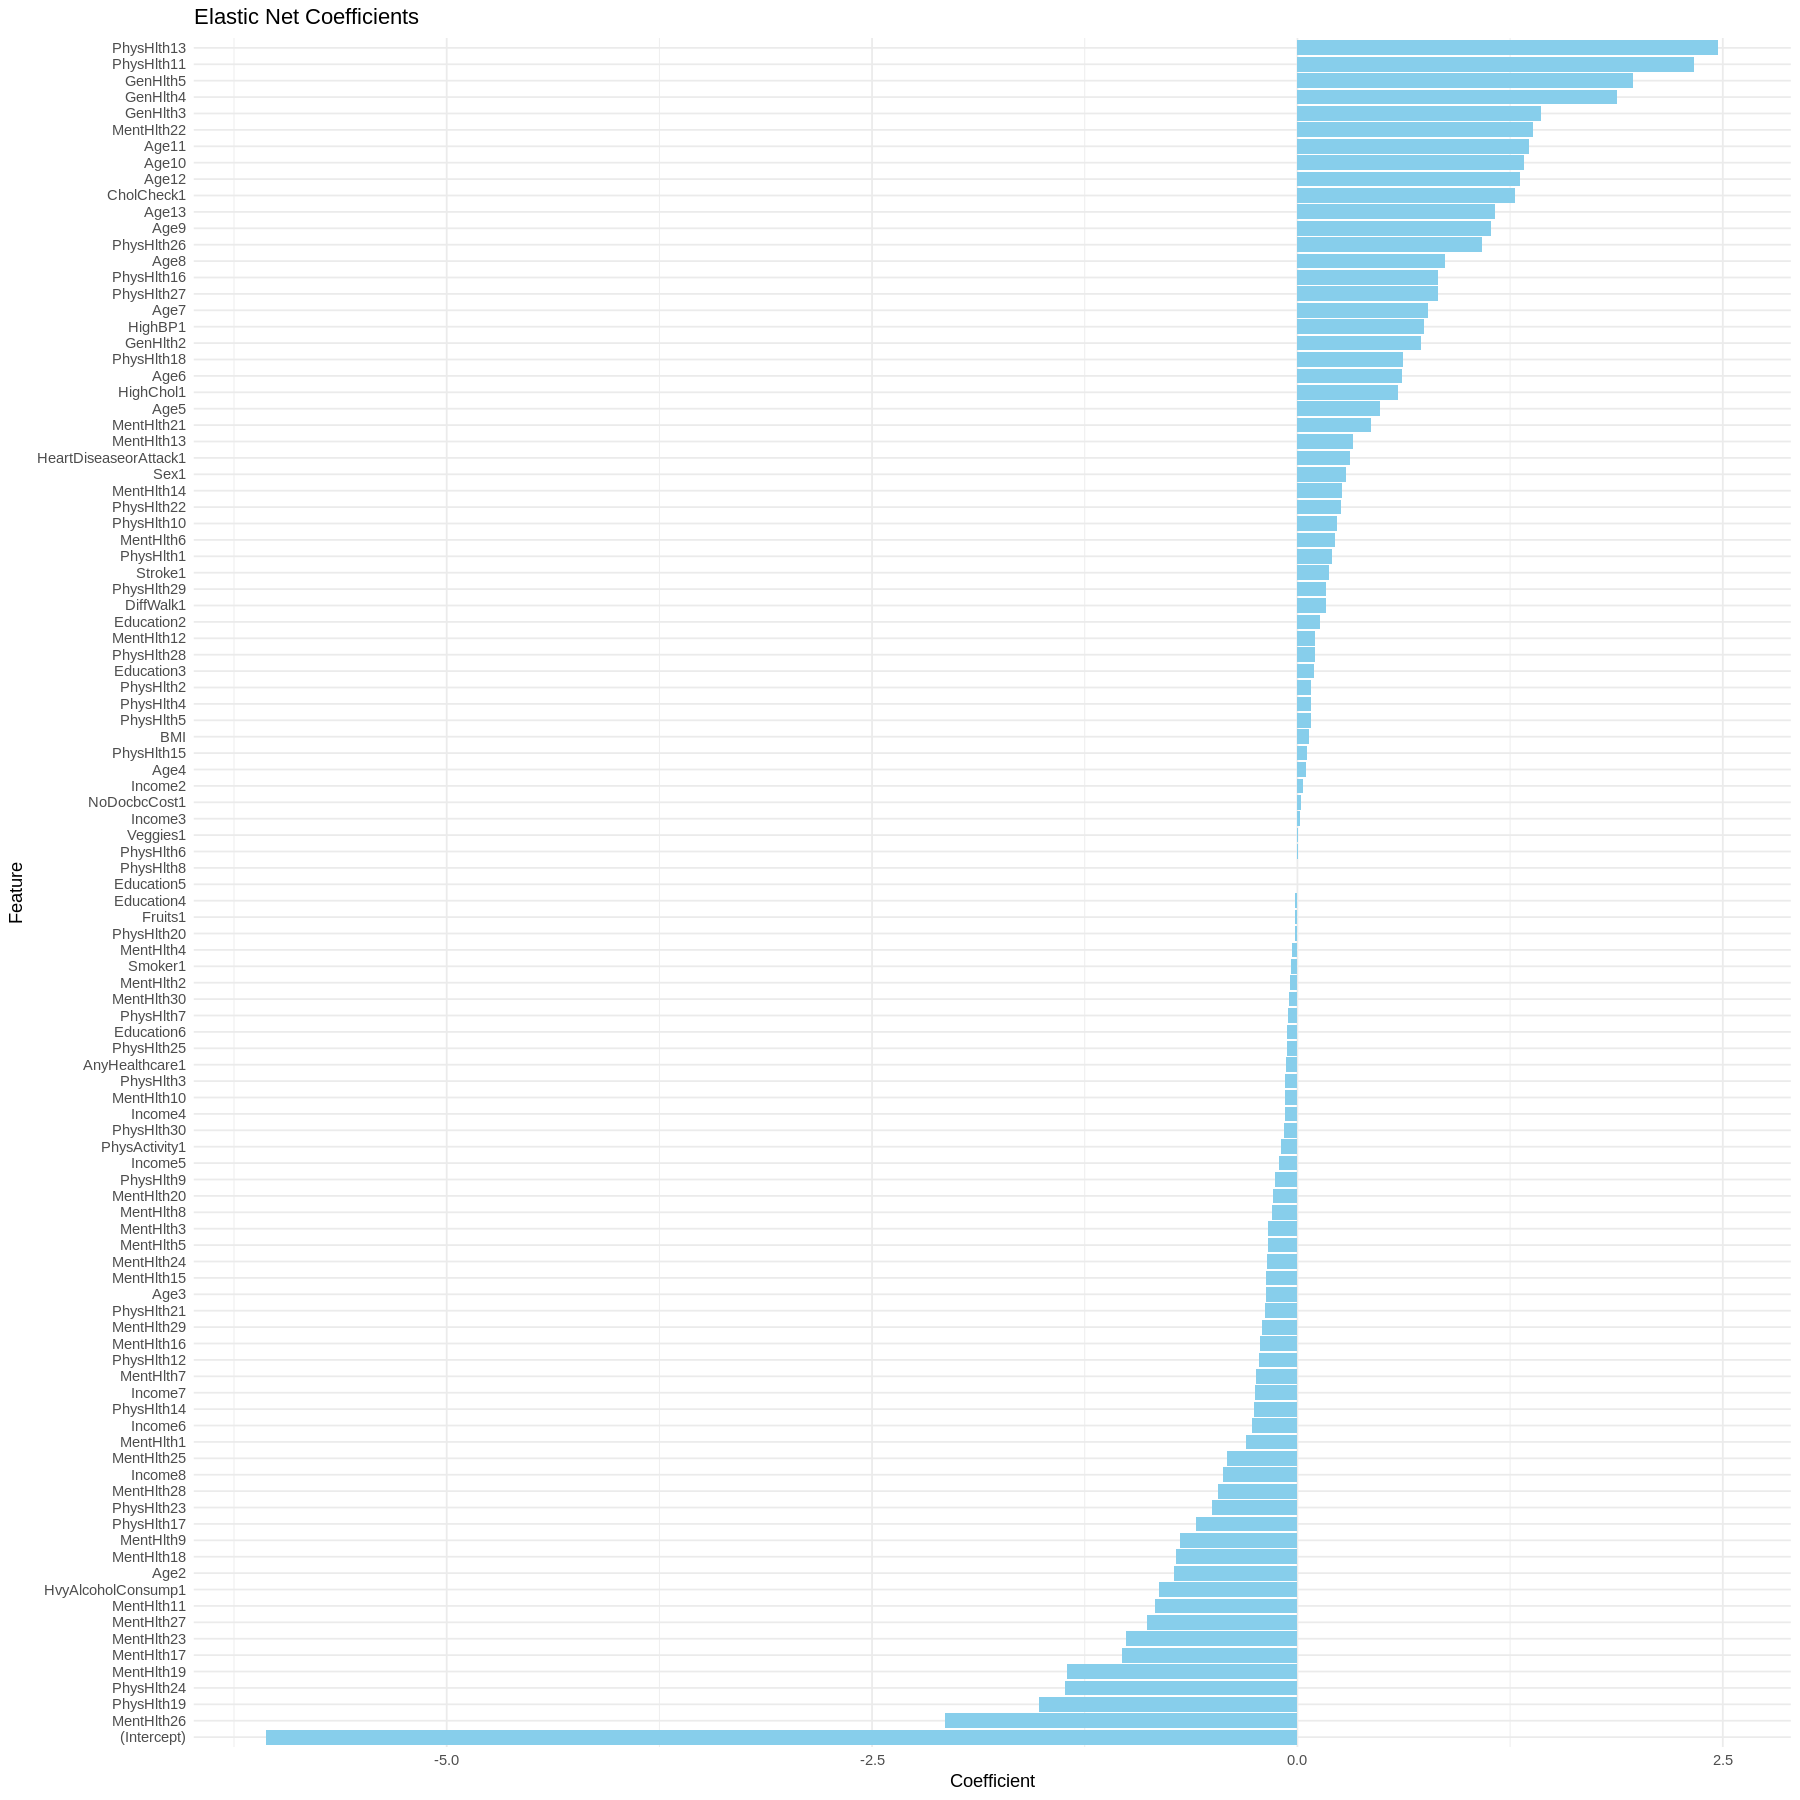

In [59]:
# Extract coefficients for feature importance
coefficients <- coef(elastic_net_model_GridTuned_Fine$finalModel,
                     elastic_net_model_GridTuned_Fine$bestTune$lambda)

# Convert to matrix then to data frame
coefficients <- as.matrix(coefficients)

coef_df <- data.frame(feature = rownames(coefficients),
                      coefficient = coefficients[,1])

# Plot the coefficients
ggplot(coef_df, aes(x = reorder(feature, coefficient), y = coefficient)) +
       geom_col(fill = "skyblue") +
       coord_flip() +
       labs(title = "Elastic Net Coefficients", x = "Feature", y = "Coefficient") +
       theme_minimal()

## Support Vector Machine Classifier Performance

In [66]:
# Make predictions using the final model
predictions_svm <- predict(svm_model_poly_GridTuned_Fine, newdata = test_data)

# Generate confusion_matrix
confusion_matrix_svm <- confusionMatrix(predictions_svm, test_data$Diabetes)

# Print output
print(confusion_matrix_svm)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  15259  5238
       Yes  5948 15969
                                         
               Accuracy : 0.7363         
                 95% CI : (0.732, 0.7405)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.4725         
                                         
 Mcnemar's Test P-Value : 2.033e-11      
                                         
            Sensitivity : 0.7195         
            Specificity : 0.7530         
         Pos Pred Value : 0.7445         
         Neg Pred Value : 0.7286         
             Prevalence : 0.5000         
         Detection Rate : 0.3598         
   Detection Prevalence : 0.4833         
      Balanced Accuracy : 0.7363         
                                         
       'Positive' Class : No             
                                      